<a href="https://colab.research.google.com/github/be-ayush/ai-ml-learning/blob/main/HOML/HOML3_Chapter_3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_openml

#As Frame is false because mnist is image dataset and it does not make sense to have images in pd dataframe
mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
X, y = mnist.data, mnist.target

print(X)
print(X.shape)
print(y)
print(y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(70000, 784)
['5' '0' '4' ... '4' '5' '6']
(70000,)


In [3]:
import plotly.express as px

# Reshape the 1D array (784,) into a 2D array (28, 28)
fig = px.imshow(X[0].reshape(28, 28), color_continuous_scale='greys')
fig.show()

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
sgd_classifier.predict(X_train[500].reshape(1, -1))

array([False])

In [8]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [9]:
from sklearn.dummy import DummyClassifier

In [10]:
dummy_classifier = DummyClassifier()
dummy_classifier.fit(X_train, y_train_5)
print(any(dummy_classifier.predict(X_train)))

False


In [11]:
cross_val_score(dummy_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [12]:
#Performance of a classifier is better understood with a confusion matrix,

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

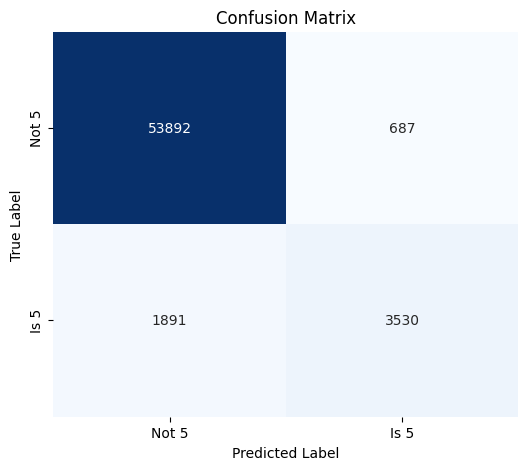

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels for clarity (0: Not 5, 1: Is 5)
class_labels = ['Not 5', 'Is 5']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
#precision is TP/(TP + FP) recall/sensitivity is TP/(TP + FN)

from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print(precision, recall)

#The way to interpret this is that when it predicts 5 it only correct precision_score % times and of all actual 5s it is only able to predict recall_score % of 5s

0.8370879772350012 0.6511713705958311


In [15]:
# Since single metric is often preferred we use F1 score (harmonic mean of precision and recall)

from sklearn.metrics import f1_score
f1 = f1_score(y_train_5, y_train_pred)
print(f1)

0.7325171197343847


In [16]:
# There is a tradeoff here since we can not build a perfect model, there will always be some false positives and some false negatives

y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method='decision_function')
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

import plotly.graph_objects as go

fig = go.Figure()
fig.add_scatter(x=thresholds, y=precisions[:-1], name='precision', line=dict(dash='dash'))
fig.add_scatter(x=thresholds, y=recalls[:-1], name='recall', line=dict(dash='dash'))
fig.add_vline(x=0.5, line_dash="dot", annotation_text="threshold")
fig.update_layout(yaxis_range=[0, 1.0])
fig.show()

In [17]:
## Suppose our project requires 90% precision

index_for_90 = (precisions >= 0.90).argmax()
threshold_for_90 = thresholds[index_for_90]
threshold_for_90

np.float64(3370.0194991439557)

In [18]:
## Now to make predictions at this threshold

y_train_pred_90 = (y_scores >= threshold_for_90)

# Re-import the functions to ensure they are callable
from sklearn.metrics import precision_score, recall_score

# Use distinct variable names for the calculated scores to avoid shadowing the imported functions
precision_at_90 = precision_score(y_train_5, y_train_pred_90)
recall_at_90 = recall_score(y_train_5, y_train_pred_90)

print(precision_at_90, recall_at_90)

0.9000345901072293 0.4799852425751706


In [20]:
##ROC Curve

from sklearn.metrics import roc_curve

# Corrected: Use y_scores instead of y_train for the second argument
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

index_for_90 = (thresholds <= threshold_for_90).argmax()

tpr_90, fpr_90 = tpr[index_for_90], fpr[index_for_90]

fig = go.Figure()
fig.add_scatter(x=fpr, y=tpr, name='ROC Curve', mode='lines')
fig.add_scatter(x=[0,1], y=[0,1], name='Random Classfier', mode='lines', line=dict(dash='dash'))
fig.add_scatter(x=[fpr_90], y=[tpr_90], mode='markers', name='Threshold for 90% precision',marker=dict(color='black', size=10))
fig.update_layout(yaxis_range=[0, 1.0])
fig.show()

In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score = roc_auc_score(y_train_5, y_scores)
print(roc_auc_score)

0.9604938554008616


In [22]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(random_state=42)

y_probabilities_forest = cross_val_predict(forest_classifier, X_train, y_train_5, cv=3, method='predict_proba')

In [24]:
y_score_forest = y_probabilities_forest[:, 1]
precision_forest, recall_forest, threshold_forest = precision_recall_curve(y_train_5, y_score_forest)

fig = go.Figure()
fig.add_scatter(x=recall_forest, y=precision_forest, name='Random Forest', mode='lines')
fig.add_scatter(x=recalls, y=precisions, name='SGD', mode='lines', line=dict(dash='dash'))
fig.update_layout(yaxis_range=[0, 1.0], xaxis_title='Recall', yaxis_title='Precision',)
fig.show()

In [26]:
y_train_pred_forest = y_probabilities_forest[:, 1] >= 0.5
f1_score_forest = f1_score(y_train_5, y_train_pred_forest)
print(f1_score_forest)

# Re-import roc_auc_score to ensure it refers to the function, not the float variable
from sklearn.metrics import roc_auc_score

# Assign the result to a new variable name to avoid shadowing
roc_auc_forest_score = roc_auc_score(y_train_5, y_score_forest)
print(roc_auc_forest_score)

0.9274509803921569
0.9983436731328145


In [29]:
from sklearn.svm import SVC

svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train[:2000], y_train[:2000])

print(svm_classifier.predict(X_train[2500].reshape(1, -1)))
some_digit_scores = svm_classifier.decision_function(X_train[2500].reshape(1, -1))
fig = px.imshow(X[2500].reshape(28, 28), color_continuous_scale='greys')
fig.show()

['0']


In [31]:
print(svm_classifier.classes_)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [34]:
from sklearn.multiclass import OneVsRestClassifier

ovr_classifier = OneVsRestClassifier(SVC(random_state=42))
ovr_classifier.fit(X_train[:2000], y_train[:2000])

print(ovr_classifier.predict(X_train[2510].reshape(1, -1)))
fig = px.imshow(X[2510].reshape(28, 28), color_continuous_scale='greys')
fig.show()

print(len(ovr_classifier.estimators_))

['2']


10


In [35]:
sgd_classfier_multiclass = SGDClassifier(random_state=42)
sgd_classfier_multiclass.fit(X_train, y_train)

print(sgd_classfier_multiclass.predict(X_train[2511].reshape(1, -1)))
fig = px.imshow(X[2511].reshape(28, 28), color_continuous_scale='greys')
fig.show()

['8']


In [36]:
print(sgd_classfier_multiclass.decision_function(X_train[2511].reshape(1, -1)))

[[-31652.47597218 -13653.45525708 -11492.55579     -4158.39243089
  -17268.61793653  -6222.04995569 -46938.67678323 -36532.5625627
    2385.9867815  -11787.39440833]]


In [37]:
cross_val_score_sgd_multiclass = cross_val_score(sgd_classfier_multiclass, X_train, y_train, cv=3, scoring='accuracy')
print(cross_val_score_sgd_multiclass)

[0.87365 0.85835 0.8689 ]


In [38]:
## Can achieve better results with input normalization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score_sgd_multiclass_scaled = cross_val_score(sgd_classfier_multiclass, x_train_scaled, y_train, cv=3, scoring='accuracy')

print(cross_val_score_sgd_multiclass_scaled)

[0.8983 0.891  0.9018]


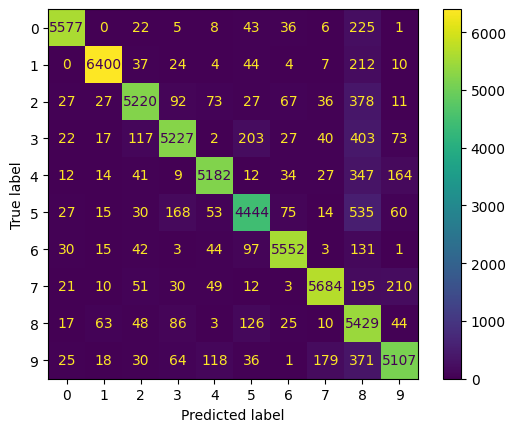

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_classfier_multiclass, x_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()